# AMATERASU tutorial

In this notebook, how to run AMATERASU.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import gzip
import pickle

sys.path.append(os.path.abspath(".."))

from amaterasu.AMATERASU import AMATERASU
from amaterasu.time_series_clean import time_series_clean

The indice table contains 9 predefined spectral lines predefined: 3 of K I, 2 of Ti I, 2 of Al I, 2 of Mn I and 1 of Fe I. The suffix "a" or "b" only serves to identify the lines more easily. "ln_win" and "interp_win" are the maximum central bandpass and interpolation/continuum windows, respectively. These are merely suggestions and may be changed at will.

In [2]:
import pandas as pd

ind_table = pd.read_csv("../ind_table.csv")
ind_table

,ln_id,ln_ctr,ln_win,interp_win
0,KI_a,11772.862,3,9
1,KI_b,12435.647,4,12
2,KI_c,12525.544,4,12
3,AlI_a,13127.011,5,15
4,AlI_b,13154.345,5,15
5,FeI,11693.408,4,12
6,MnI,12903.289,4,12
7,TiI_a,10498.989,3,9
8,TiI_b,12825.181,3,9


Let's run AMATERASU in NIRPS observations of Proxima Centauri. The way you extract the data is irrelevant, as long the final arrays to feed the tool have the dimensions printed below and are RV corrected. We also note that the data we used are telluric corrected.

In [3]:
with gzip.open("Proxima_data.pkl.gz", "rb") as f:
    data = pickle.load(f)

bjd_observations = data["bjd"]
fwhm_array = data["fwhm"]
wavelengths = data["wavelengths"]
fluxes = data["fluxes"]
flux_errors = data["flux_errors"]
spectra_observations = np.stack([wavelengths, fluxes, flux_errors], axis=1)
spectra_observations.shape

(57, 3, 30, 4084)

In [4]:
print("CCF FWHM array shape: ",fwhm_array.shape)
print("BJD array shape: ",bjd_observations.shape)
print("spectra observations array shape: ",spectra_observations.shape)


CCF FWHM array shape:  (57, 2)
BJD array shape:  (57,)
spectra observations array shape:  (57, 3, 30, 4084)


As a test, let's first extract the period of CCF FWHM, known to closely follow stellar activity.

In [6]:
df_fwhm = pd.DataFrame({"BJD":bjd_observations,"fwhm":fwhm_array[:,0],"fwhm_error":fwhm_array[:,1]})
df_fwhm_clean = time_series_clean(df_fwhm, ["fwhm"], ["fwhm_error"], sigma=3, sigma_clip=True, bin_night=True).df

star = "Proxima Centauri"
ind = "fwhm"
bandpasses = ["fwhm"]
fap_treshold = 0.001

gls_df, all_gls_df = AMATERASU._compute_gls(star,ind,bandpasses,None,fap_treshold,df_fwhm_clean,bandpasses,
                                            False,output="standard",
                                            spec_lines_folder=None)

gls_df

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


,bandpass,period,FAP
0,fwhm,[79.9184093432801],[7.973494514656898e-09]


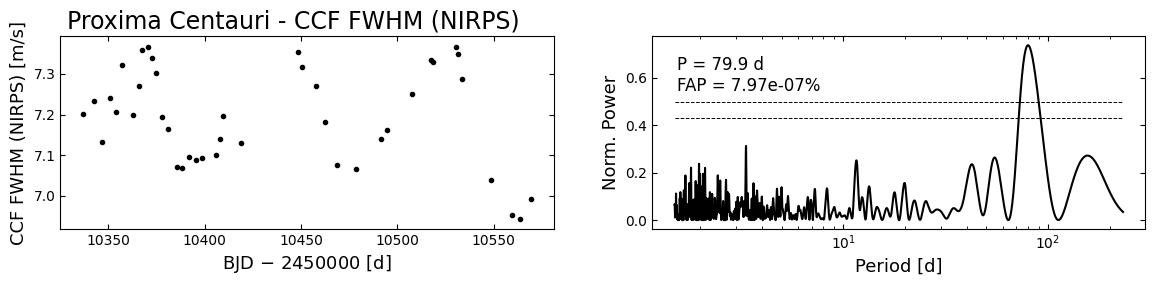

In [7]:
fig, axes = plt.subplots(ncols=2,figsize=(14, 0.5+2), sharex="col")

col = "fwhm"
results = all_gls_df.iloc[0].to_dict()

axes[0].errorbar(df_fwhm_clean["BJD"] - 2450000, df_fwhm_clean[col], df_fwhm_clean[col+"_error"], fmt="k.")

axes[0].set_ylabel(rf"CCF FWHM (NIRPS) [m/s]", fontsize=13)
axes[0].set_xlabel("BJD $-$ 2450000 [d]", fontsize=13)
axes[0].tick_params(axis="both", direction="in", top=True, right=True, which='both')

axes[1].semilogx(results["period"], results["power"], "k-")
axes[1].plot([min(results["period"]), max(results["period"])], [results["fap01_power"]] * 2,"--",color="black",lw=0.7)
axes[1].plot([min(results["period"]), max(results["period"])], [results["fap1_power"]] * 2,"--",color="black",lw=0.7)

axes[1].set_ylabel("Norm. Power", fontsize=13)
axes[1].set_xlabel("Period [d]", fontsize=13)
axes[1].tick_params(axis="both", direction="in", top=True, right=True, which='both')
axes[1].text(0.05, 0.9,f"P = {np.around(results['period_best'], 1)} d \nFAP = {results['fap_best']*100:.2e}%",fontsize=12,transform=axes[1].transAxes,verticalalignment="top")

fig.subplots_adjust(hspace=0.0)
fig.text(0.13, 0.91, f"{star} - CCF FWHM (NIRPS)", fontsize=17)

plt.show()

We will test two spectral lines: K I (b) and (c). The input periods will be value close to the literature rotation period with an uncertainty, the tolerance will be 10 d and the FAP threshold for detection is 0.1%.

For the correlations, we will test with the CCF FWHM of NIRPS observations, using a treshold of $\rho_S \geq 0.4$ and p-val of 0.1% for the absolute correlation to be considered "strong".

Below all input for AMATERASU is shown.

In [8]:
#options for AMATERASU

star = "Proxima" #star name

data = [bjd_observations, spectra_observations]

run_gls = True
#periods that will be tested. two of them close to the real rotation period of Proxima and one close to the orbital period of Proxima b
period_test = [[80,5],[85,8],[11,2]]
ptol = [10,10,2] #10 days of tolerance for higher periods, 2 for the lower
fap_treshold = 0.001
plot_gls=True 
gls_options = [run_gls, period_test, ptol, fap_treshold, plot_gls]


run_correlation=True
df_fwhm = pd.DataFrame({"BJD":bjd_observations,"fwhm":fwhm_array[:,0],"fwhm_err":fwhm_array[:,1]})
cols_input = ["fwhm"]
cols_err_input = ["fwhm_err"]
abs_corr_threshold=0.4
pval_threshold=0.001
correlation_options = [run_correlation, df_fwhm, cols_input, cols_err_input, abs_corr_threshold, pval_threshold]

#spectral lines to be tested:

indices = ["KI_b","KI_c"]

indice_info = {
                "KI_b":{'ln_ctr':12435.647},
                "KI_c":{'ln_ctr':12525.544},
                }

Now let's run the "standard" version of AMATERASU, the simplest. We give the star name, data, lines names and centers, options for GLSPs and correlations and the folder to save.

AMATERASU instance created for Proxima


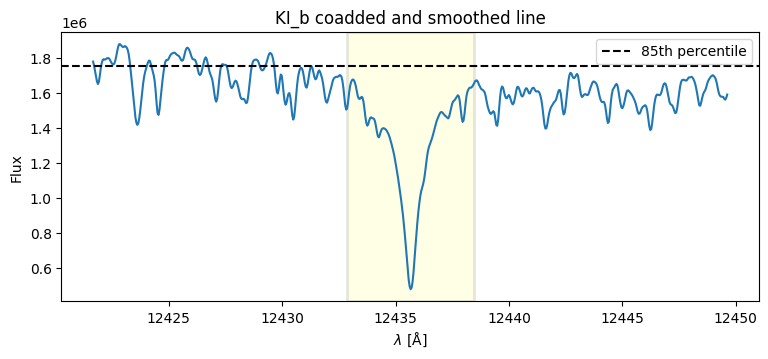

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_b
Line center: 12435.647
Number of spectra: 57
--------------------------------------------------------------------------------
Maximum Bandpass: 5.6
Interpolation window: 28.0
--------------------------------------------------------------------------------


100%|██████████| 57/57 [00:08<00:00,  6.64it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 56/56 [00:08<00:00,  6.51it/s]


Bandpass with period near to input and lowest FAP: 2.2
Period [d]: 80.73038065864814
FAP: 1.74e-13
Number of bandpasses that detect period near to input: 55
    bandpass                period                        FAP input_period
0        0.1  (79.79169405198793,)   (4.737062435694401e-10,)     [80, 85]
1        0.2  (79.91840934328012,)   (8.679949846472023e-11,)     [80, 85]
2        0.3  (79.79169405198793,)   (3.535738539213117e-05,)     [80, 85]
3        0.4  (80.86009732209395,)  (0.00023875647881416599,)     [80, 85]
4        0.5  (88.59459953569394,)   (0.0005646013196443635,)     [80, 85]
5        0.7  (83.73021493853577,)  (1.4126847934869375e-05,)     [80, 85]
6        0.8  (82.58515698423919,)    (5.72575862316438e-07,)     [80, 85]
7        0.9  (80.21564932730047,)  (4.4217724604132675e-08,)     [80, 85]
8        1.0  (80.51510861075614,)  (1.3766930497826464e-09,)     [80, 85]
9        1.1  (80.81681214190178,)   (1.286458007476359e-10,)     [80, 85]
10       1.2  (80.

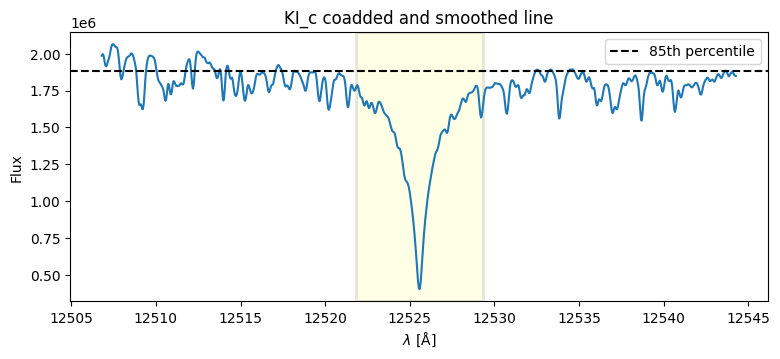

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_c
Line center: 12525.544
Number of spectra: 57
--------------------------------------------------------------------------------
Maximum Bandpass: 7.5
Interpolation window: 37.5
--------------------------------------------------------------------------------


100%|██████████| 57/57 [00:11<00:00,  4.92it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 75/75 [00:11<00:00,  6.59it/s]


Bandpass with period near to input and lowest FAP: 0.1
Period [d]: 81.29551302793118
FAP: 1.26e-15
Number of bandpasses that detect period near to input: 71
    bandpass                period                        FAP input_period
0        0.1  (81.29551302793118,)  (1.2632114808593087e-15,)     [80, 85]
1        0.3  (81.64723646405861,)  (1.0174620869694313e-08,)     [80, 85]
2        0.7   (79.9607372582091,)  (2.4685265887918913e-10,)     [80, 85]
3        0.8  (80.64413385034602,)   (5.835918733697561e-10,)     [80, 85]
4        0.9  (80.42932090862318,)   (7.464141931047198e-13,)     [80, 85]
..       ...                   ...                        ...          ...
66       7.1  (80.90342889389224,)   (3.105711707700728e-11,)     [80, 85]
67       7.2  (80.81681214190178,)  (3.7026305717387237e-11,)     [80, 85]
68       7.3  (80.86009732209395,)  (4.4993223630033556e-11,)     [80, 85]
69       7.4  (80.86009732209395,)  (2.7143089108180395e-11,)     [80, 85]
70       7.5  (80.

In [9]:
amaterasu = AMATERASU(star, data, indices, indice_info, gls_options, correlation_options, 
                      output="standard", 
                      folder_path=f"tutorial_results_standard/", 
                      plot_line=True)

As we can see, both lines are able to detect Proxima's rotation period quite nicely in the majority of central bandpasses, as well as strong correlation with the CCF FWHM of NIRPS.

Finally, let's test AMATERASU with the "full" output.

AMATERASU instance created for Proxima


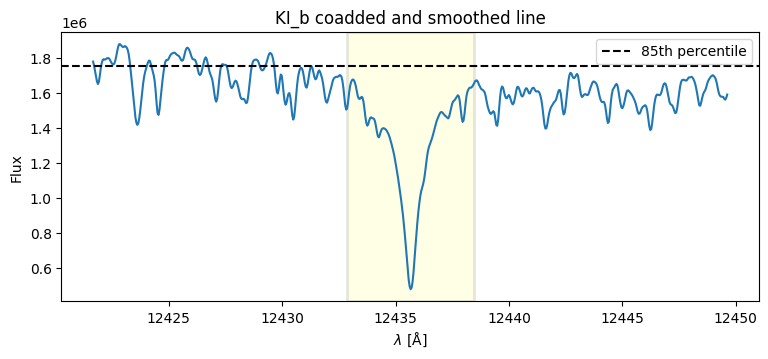

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_b
Line center: 12435.647
Number of spectra: 57
--------------------------------------------------------------------------------
Maximum Bandpass: 5.6
Interpolation window: 28.0
--------------------------------------------------------------------------------


100%|██████████| 57/57 [00:08<00:00,  6.35it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 56/56 [01:30<00:00,  1.61s/it]


Bandpass with period near to input and lowest FAP: 2.2
Period [d]: 80.73038065864814
FAP: 1.74e-13
Number of bandpasses that detect period near to input: 55
    bandpass                period                        FAP input_period
0        0.1  (79.79169405198793,)   (4.737062435694401e-10,)     [80, 85]
1        0.2  (79.91840934328012,)   (8.679949846472023e-11,)     [80, 85]
2        0.3  (79.79169405198793,)   (3.535738539213117e-05,)     [80, 85]
3        0.4  (80.86009732209395,)  (0.00023875647881416599,)     [80, 85]
4        0.5  (88.59459953569394,)   (0.0005646013196443635,)     [80, 85]
5        0.7  (83.73021493853577,)  (1.4126847934869375e-05,)     [80, 85]
6        0.8  (82.58515698423919,)    (5.72575862316438e-07,)     [80, 85]
7        0.9  (80.21564932730047,)  (4.4217724604132675e-08,)     [80, 85]
8        1.0  (80.51510861075614,)  (1.3766930497826464e-09,)     [80, 85]
9        1.1  (80.81681214190178,)   (1.286458007476359e-10,)     [80, 85]
10       1.2  (80.

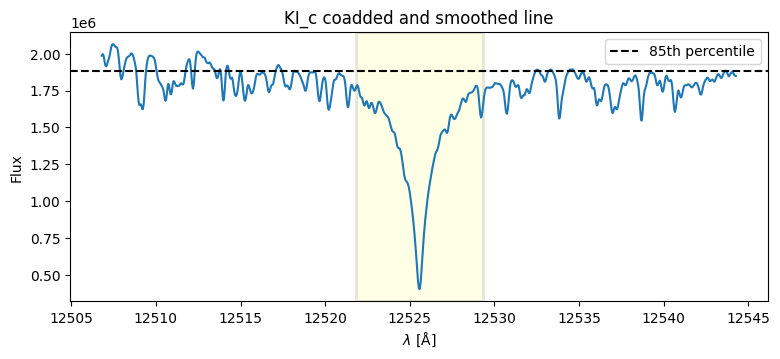

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_c
Line center: 12525.544
Number of spectra: 57
--------------------------------------------------------------------------------
Maximum Bandpass: 7.5
Interpolation window: 37.5
--------------------------------------------------------------------------------


100%|██████████| 57/57 [00:12<00:00,  4.53it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 75/75 [02:37<00:00,  2.10s/it]


In [ ]:
amaterasu = AMATERASU(star, data, indices, indice_info, gls_options, correlation_options,
                    output="full", 
                    plot_line=True, folder_path="tutorial_results_full")

As a final exercise, let's plot the period with lowest FAP for each central bandpass of each line in function of the central bandpass.

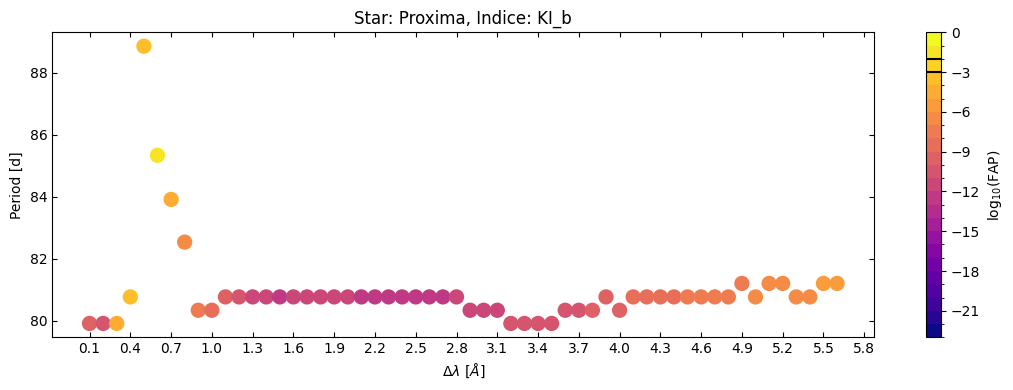

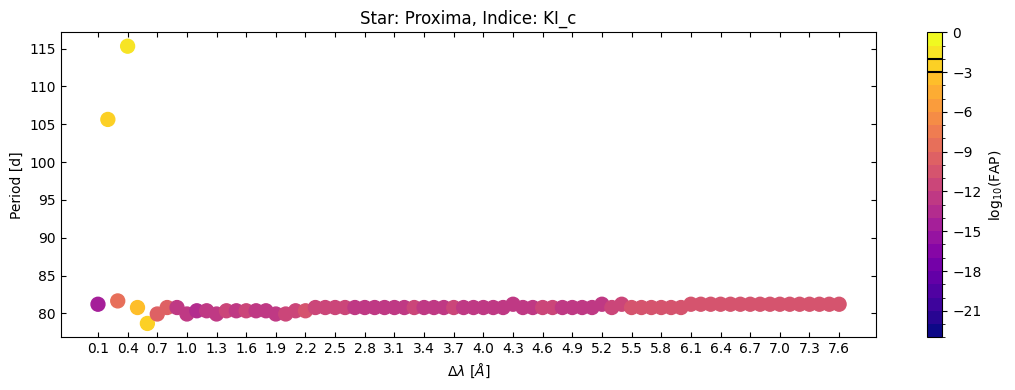

In [ ]:
import ast
import matplotlib.colors as mcolors 

def periods_bandpass_plot(star, indice):

    df_gls = pd.read_csv(f"tutorial_results_full/{star}/{indice}/periods_full_{star}_{indice}.csv")

    cmap = plt.get_cmap("plasma")
    log_FAP_min, log_FAP_max = 0, -23 #-23 is an arbitrary choice based on the lowest FAP, technically we could go to -99
    boundaries = np.arange(log_FAP_max, log_FAP_min + 1, 1) 
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 4))

    axes.set_title(f"Star: {star}, Indice: {indice}")

    periods = []; faps = []

    for i in range(len(df_gls["sel_peaks_period"])):
        periods.append(ast.literal_eval(df_gls["sel_peaks_period"][i])[0])
        faps.append(ast.literal_eval(df_gls["sel_peaks_FAP"][i])[0])

    bandpasses = np.array(range(1,len(df_gls["sel_peaks_period"])+1))/10
    sc1 = axes.scatter(bandpasses, periods, c=np.log10(faps), cmap=cmap, marker="o", s=100, norm=norm)

    axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]"); axes.set_ylabel(r"Period [d]")
    cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(FAP)")
    cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
    cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

    axes.set_xticks(np.arange(np.min(bandpasses),np.max(bandpasses)+0.3,0.3))
    axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
    plt.tight_layout()

for ind in indices:
    periods_bandpass_plot(star, ind)

plt.show()

Let's do the same but for the Spearman correlation with CCF FWHM (NIRPS).

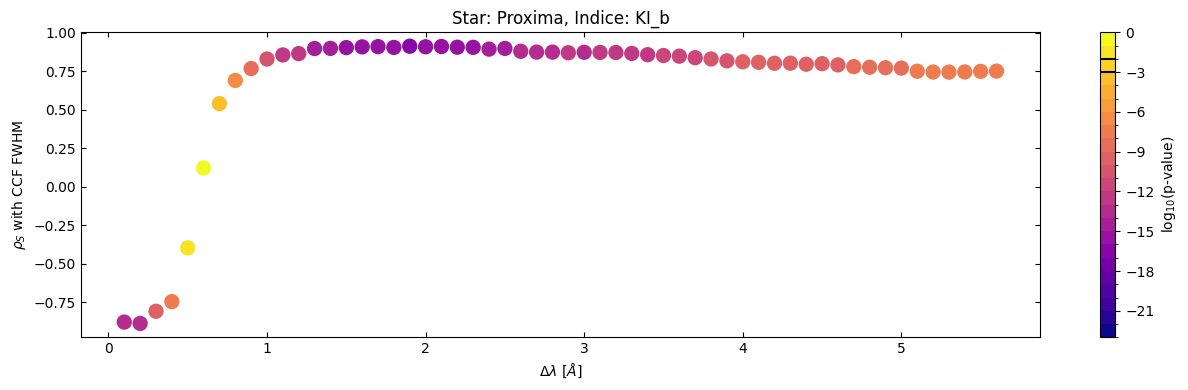

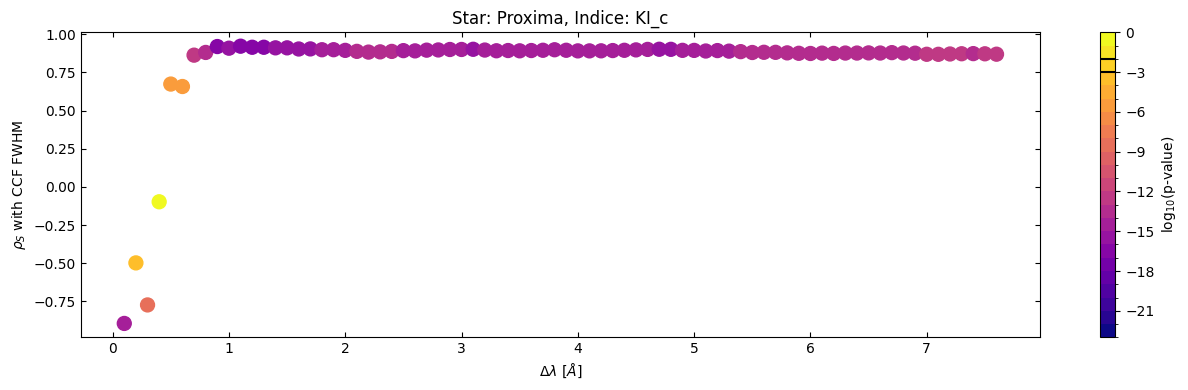

In [11]:
def correlation_bandpass_plot(star, indice):

    df_correlations = pd.read_csv(f"tutorial_results_full/{star}/{indice}/correlations_{star}_{indice}.csv")

    cmap = plt.get_cmap("plasma")
    log_pval_min, log_pval_max = 0, -23
    boundaries = np.arange(log_pval_max, log_pval_min + 1, 1)  # Intervals of 1
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(13, 4))

    axes.set_title(f"Star: {star}, Indice: {indice}")
    sc1 = axes.scatter(df_correlations["bandpass"], df_correlations["rho_fwhm"], c=np.log10(df_correlations["pval_fwhm"]), cmap=cmap, marker="o", s=100, norm=norm)

    axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]")
    axes.set_ylabel(r"$\rho_S$ with CCF FWHM")
    cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(p-value)")
    cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
    cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

    axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
    plt.tight_layout()

for ind in indices:
    correlation_bandpass_plot(star, ind)

plt.show()